In [48]:
using Pkg
pkg"activate .; instantiate; precompile"

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Precompiling project...


In [7]:
using PerlaTonettiWaugh, Plots, BenchmarkTools, CSV, JSON, DataFrames, Parameters
gr(fmt = :png) # display plots as PNG

Plots.GRBackend()

# Steady states

## Solving steady state solutions

Set up parameters and find the corresponding stationary solution:

Below are the results from the **updated** matlab calibration with the corresponding letters. Here I added the $\mu$ parameter in the calibration routine to fit the firm dynamic moments. Fit improved a lot and it generated a negative drift term which is what we need to keep S from going negative.


In [9]:
params = parameter_defaults();
settings = settings_defaults(run_global = false); # solver settings. 

Side note on previous version. Essentially, under this calibration, the parameters are very simmilar. Theta, chi, kappa are quite close to what we had in the prior version.

In [10]:
# solve for stationary solutions at t = 0
@unpack stationary_0, stationary_T, change_welfare, change_trade = compare_steady_states(params, settings)

(stationary_0 = (F = getfield(PerlaTonettiWaugh, Symbol("#F#28")){Float64}(5.0018), r = 0.04845708813238998, ν = 1.5026890308561498, a = 10.852299696088764, b = 0.6040638931653957, S = 0.10002889658564101, L_tilde = 0.23194242838705795, L_tilde_x = 0.02079280028659783, L_tilde_E = 0.11478688884308892, L_tilde_a = 0.09636273925737122, z_bar = 1.343947494516949, w = 0.9203233827700777, x = 1.0, π_min = 0.18600449465185323, π_rat = 1.8110075391436142, g = 0.006957088132389982, z_hat = 1.9806967954630184, Ω = 0.9633490175998196, v_tilde = [4.95047, 4.94326, 4.93607, 4.92889, 4.92174, 4.9146, 4.90747, 4.90037, 4.89328, 4.88621  …  3.63631, 3.63661, 3.63684, 3.63691, 3.63663, 3.63528, 3.63058, 3.61516, 3.56543, 3.40563], y = 1.0322290490139856, c = 1.0322290490139856, λ_ii = 0.8960256258123868, U_bar = 16.5258643572831), stationary_T = (F = getfield(PerlaTonettiWaugh, Symbol("#F#28")){Float64}(5.0018), r = 0.05033095999849095, ν = 1.4122787465784583, a = 10.393135471618786, b = 0.52736983455

We can inspect the returned objects

In [13]:
change_welfare

7.85513459322873

In [14]:
change_trade

0.03807150525622016

In [16]:
for (k,v) in zip(keys(stationary_0), values(stationary_0)) # can replace this with stationary_T if we wish
#     println(k, " => ", v) # uncomment this line to display the full solution
end

### This is the autarky calculation

In [18]:
# Solve for the autarky case 
params_autarky = parameter_defaults(d = 1 + (params.d_0-1)*2.5)
stationary_autarky = stationary_algebraic(params_autarky, settings) # solution at t = T
lambda_ss_autarky = 100*(consumption_equivalent(stationary_autarky.U_bar, stationary_0.U_bar, parameter_defaults())-1)

print("SS to SS welfare gain: ", lambda_ss_autarky,"\n")
print("Autarky Home Share, should be close to 1: ", stationary_autarky.λ_ii,"\n")
print("Autarky TFP growth rate ", stationary_autarky.g,"\n")

SS to SS welfare gain: -16.279999170528846
Autarky Home Share, should be close to 1: 0.9965183434231
Autarky TFP growth rate 0.002438078962924379


## Welfare in Steady States

### Steady state at `T`

In [19]:
stationary_T.U_bar

20.043017583647885

### Steady state at `0`

In [20]:
stationary_0.U_bar

16.5258643572831

### Outstanding Issue \#1: Sensitivity of growth to trade.

This is a big difference relative to previous version. As noted above, with parameter values that are quite similar to what we had before, the growth rate is changing a lot with only a very small change in trade flows. Why?

In [21]:
@show stationary_T.g, stationary_0.g;

(stationary_T.g, stationary_0.g) = (0.008830959998490956, 0.006957088132389982)


---

# Transition dynamics

Find the corresponding solution

In [22]:
cachename = join(hash((parameters = params, settings = settings))) # uniquely identify the run by parameters + settings
cachepath = joinpath(pwd(), "data", cachename * ".csv")
use_cache = true # change this to false if you don't want to use the cache for a run
write_cache = true # change this to false if you don't want to generate *any* cache files for a run

# reading
if isfile(cachepath) && use_cache 
    println("using cache.")
    solved = CSV.read(cachepath); 
else
    println("solving without cache.")
    @time solution = solve_transition(params, settings);
    # solved is our dataframe of results
    solved = prepare_results(solution.solve_dynamics_output, stationary_T, stationary_0) # since these are the steady-states we're using
end
    
# writing 
if write_cache
    mkpath(joinpath(pwd(), "data")) # if this doesn't eist for whatever reason
    CSV.write(cachepath, solved) # write DataFrame 
    write(joinpath(pwd(), "data", cachename * ".json"), JSON.json((parameters = params, settings = merge(settings, (interp = typeof(settings.interp),))))) # write parameters
else
    # nothing 
end
        
dropmissing!(solved) # don't plot pre-shock values

using cache.


┌ Warning: dropmissing! will change eltype of cols to disallow missing by default. Use dropmissing!(df, cols, disallowmissing=false) to retain missing.
│   caller = dropmissing!(::DataFrame) at abstractdataframe.jl:733
└ @ DataFrames /home/arnavsood/.julia/packages/DataFrames/IKMvt/src/abstractdataframe/abstractdataframe.jl:733


,t,g,z_hat,Ω,E,v_1,entry_residual,L_tilde,λ_ii,S,z_bar,c,π_min,log_M,U,π_rat,L_tilde_a,L_tilde_x,L_tilde_E,w,r
,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,0.0,0.00751913,1.87128,0.963349,0.0170201,4.93639,-0.0141014,0.224383,0.863194,0.10284,1.36724,1.06045,0.180953,0.0,20.1418,2.20653,0.0990709,0.0276282,0.097684,0.936274,0.0275674
2,0.5,0.0075657,1.87031,0.961921,0.0170448,4.93843,-0.0120601,0.224488,0.86302,0.103073,1.36643,1.05968,0.18116,0.00377121,20.3292,2.20718,0.0991481,0.0276593,0.0976811,0.935722,0.0276202
3,1.0,0.00761226,1.86932,0.960506,0.0170696,4.9405,-0.00998416,0.224596,0.862844,0.103306,1.36564,1.05892,0.181365,0.0075657,20.5171,2.20783,0.099226,0.0276913,0.0976792,0.935176,0.0276724
4,1.5,0.00765884,1.86835,0.959106,0.0170944,4.94251,-0.00797011,0.224706,0.86267,0.103539,1.36485,1.05816,0.181567,0.0113835,20.7055,2.20848,0.0993048,0.0277228,0.0976783,0.934635,0.027724
5,2.0,0.00770551,1.86741,0.95772,0.0171191,4.94437,-0.00611444,0.224816,0.862501,0.103772,1.36406,1.0574,0.181769,0.0152246,20.8944,2.20911,0.0993848,0.0277524,0.0976784,0.934096,0.0277731
6,2.03803,0.00770906,1.86734,0.957615,0.017121,4.9445,-0.0059825,0.224824,0.862489,0.10379,1.364,1.05734,0.181784,0.0155177,20.9087,2.20915,0.0993909,0.0277545,0.0976784,0.934056,0.0277877
7,2.5,0.00775163,1.86649,0.956347,0.0171439,4.94615,-0.00432541,0.224924,0.862335,0.104003,1.36328,1.05665,0.181969,0.0190889,21.0837,2.20972,0.099463,0.0277813,0.0976795,0.933563,0.0278452
8,3.0,0.00779695,1.86555,0.954988,0.0171686,4.94802,-0.00245433,0.225031,0.862166,0.10423,1.36251,1.0559,0.182167,0.0229761,21.2735,2.21035,0.0995381,0.0278117,0.0976816,0.933036,0.0278937
9,3.5,0.0078425,1.86462,0.953643,0.0171934,4.94987,-0.000606612,0.225142,0.861998,0.104458,1.36175,1.05516,0.182362,0.0268859,21.4637,2.21098,0.0996152,0.0278421,0.0976847,0.932515,0.0279297


---
## Welfare Gains

In [23]:
print("Utility in initial SS: ", stationary_0.U_bar,"\n")
print("Utility in new SS: ", stationary_T.U_bar,"\n")

Utility in initial SS: 16.5258643572831
Utility in new SS: 20.043017583647885


In [24]:
print("Utility immediately after change ", solved.U[1],"\n")

Utility immediately after change 20.141778041136263


#### Summary so far...

In the old paper, what we did was take U_0_ss at some date t, then compare it to U_ss at the same date t. This is like an instantaneous jump to the new ss. This is what the first cell is looking at and note that this is like a 17 percent increase in utility. Higher than what we had in the paper, but in of the same order of magnitude. 

The next cell reprots the utility just after the change. Utility here includes the future path of consumption and change in growth rate, so it "bakes in" the transition path. Here it goes up by much more than utility in the new SS. This is what I was expecting given the dynamics of consumption. 

In [25]:
solved.r[100] + 0.05
stationary_0.r

0.04845708813238998

Just a reminder about how the function `counsumption_equivalent(U_new, U_old, parameters)` works, it takes U_new and then U_old in that order, then evaluates the **gross** increase in consumption. 100 times this value **minus one** gives the permanent, percent increase in consumption required to make the agent indifferent between the two paths. 

In [26]:
#T = solved.t[end]
lambda_ss = 100*(consumption_equivalent(stationary_T.U_bar, stationary_0.U_bar, parameter_defaults())-1)
print("SS to SS welfare gain: ", lambda_ss,"\n")

SS to SS welfare gain: 7.85513459322873


In [27]:
lambda_tpath = 100*(consumption_equivalent(solved.U[1], stationary_0.U_bar, parameter_defaults())-1)

print("Inclusive of the Transition Path: ", lambda_tpath,"\n")

Inclusive of the Transition Path: 8.084392086373127


### Relative to initial notebook computations

- SS to SS, the issue here is that we should compare **at date 0** utility in the first ss vs. the second ss. This is what we must have been doing in the previous version of the paper. The previous calulation in the old notebook had 
```consumption_equivalent(solved.U[end], stationary_sol_0.U_bar, parameters)```
which took **date T** utility and compard them. The problem is that this now depends on date T. So if we picked T to be arbitraily large, then utility will be arbitraily different.

- Following the same logic, the transition path should compare **date 0** utility with the initial value from the transition path. So what we want to do is to compare everything at 0. In the previous calculation, we had
```consumption_equivalent(solved.U[1], stationary_sol_0.U_bar, parameters)```
were comparing the initial utility relative to ss utility on the old path at date T. So the initial blue point below versues the last orange dashed point. **See the figure below**

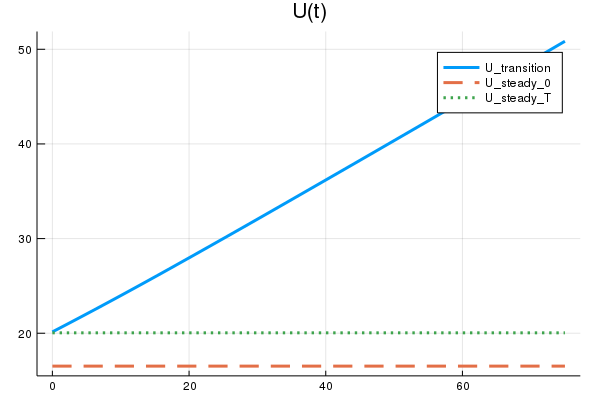

In [28]:
# generate the plot!
U_steady_0(t) = stationary_0.U_bar
U_steady_T(t) = stationary_T.U_bar

plot(solved.t, 
    [solved.U, U_steady_0, U_steady_T], 
    label = ["U_transition", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

### Outstanding Issue \#2: Welfare Gains still depend on T in transition path.

The stuff above I think is correct, the one issue is why does the welfare gains, inclusive of the transition path seem to depend on T??? So change T above from 40 to 75 or 100, then the welfare gains fall alot? Why?

---
## Plotting

In [29]:
solved.U[end]

50.848691996988435

## Plots for Ω and residuals

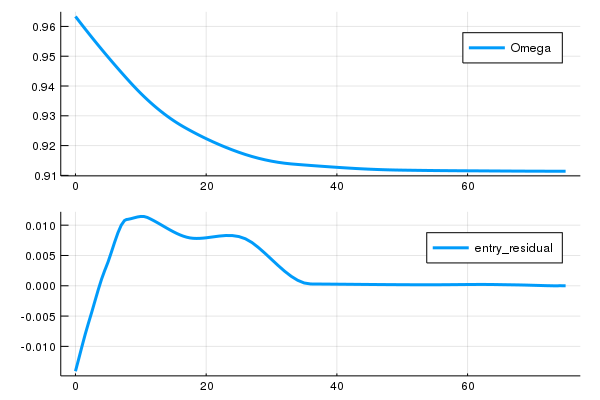

In [30]:
#solved = solved.results;
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

## Primary Plots

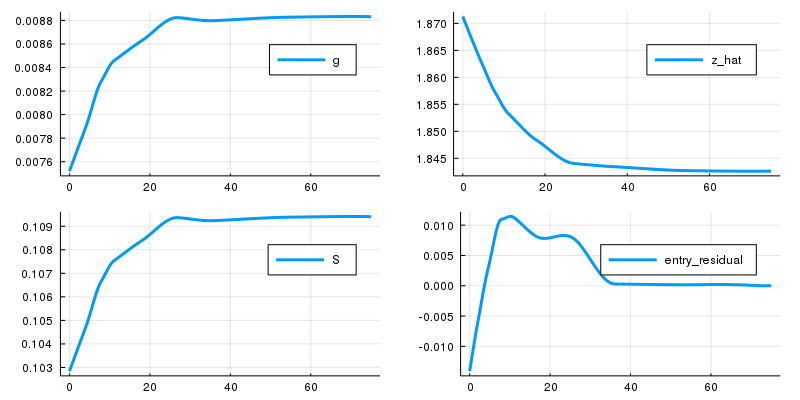

In [31]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2), size = (800, 400))

## Static Equations

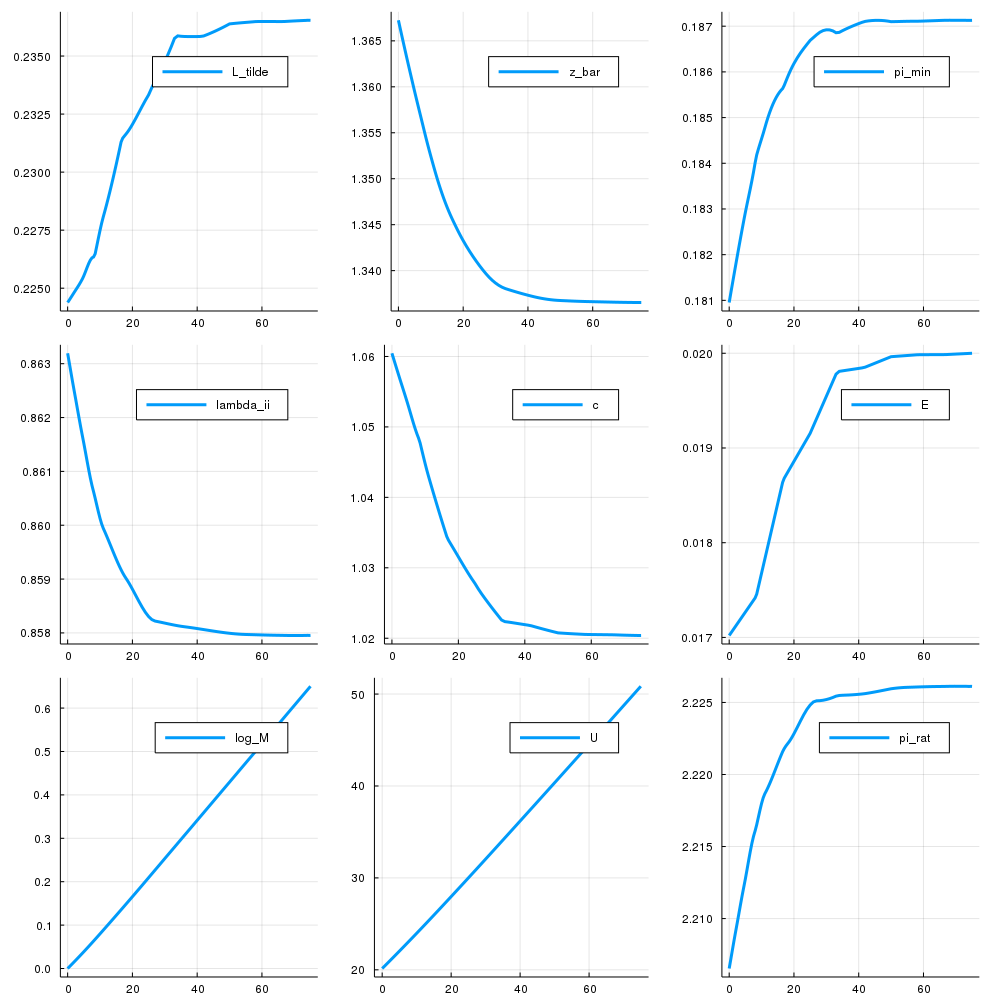

In [32]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_min, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot9 = plot(solved.t, solved.π_rat, label = "pi_rat", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, plot9, layout=(3,3), size = (1000, 1000))

# Welfare analysis

### `log_M(t)`

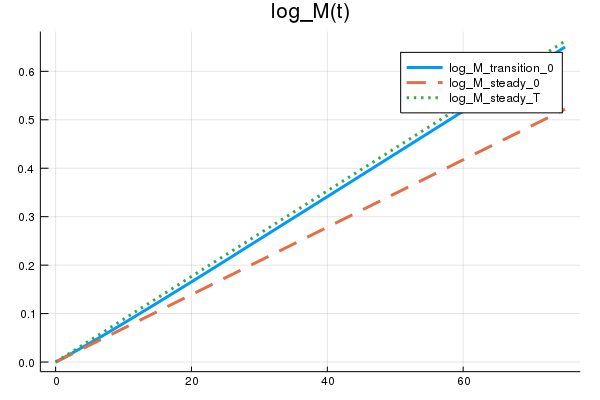

In [33]:
# define log_M with steady state g
log_M_steady_0(t) = stationary_0.g * t
log_M_steady_T(t) = stationary_T.g * t

# generate the plot!
plot(solved.t, 
    [solved.log_M, log_M_steady_0, log_M_steady_T], 
    label = ["log_M_transition_0", "log_M_steady_0", "log_M_steady_T"] ,
    title = "log_M(t)", linestyle = :auto, lw = 3)

### `Ω(t)`

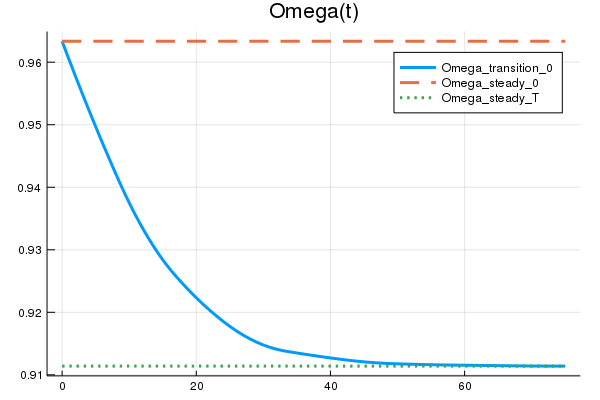

In [34]:
# define Ω function (constant)
Ω_steady_0(t) = stationary_0.Ω
Ω_steady_T(t) = stationary_T.Ω

# generate the plot!
plot(solved.t, 
    [solved.Ω, Ω_steady_0, Ω_steady_T], 
    label = ["Omega_transition_0", "Omega_steady_0", "Omega_steady_T"] ,
    title = "Omega(t)", linestyle = :auto, lw = 3)

### `c(t)`

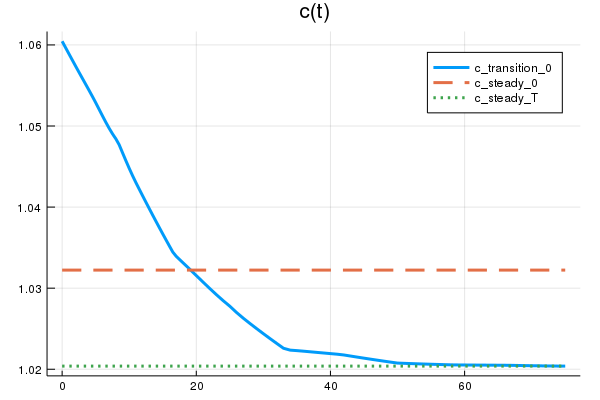

In [35]:
# define c function (constant)
c_steady_0(t) = stationary_0.c
c_steady_T(t) = stationary_T.c

# generate the plot!
plot(solved.t, 
    [solved.c, c_steady_0, c_steady_T], 
    label = ["c_transition_0", "c_steady_0", "c_steady_T"] ,
    title = "c(t)", linestyle = :auto, lw = 3)

### `U(t)`

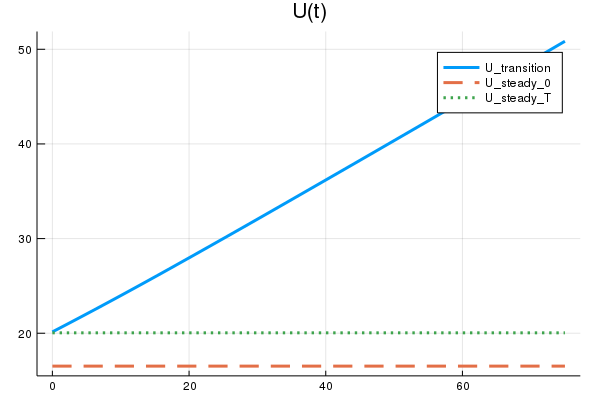

In [36]:
# generate the plot!
U_steady_0(t) = stationary_0.U_bar
U_steady_T(t) = stationary_T.U_bar

plot(solved.t, 
    [solved.U, U_steady_0, U_steady_T], 
    label = ["U_transition", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

## Consumption equivalent for search threshold (`M(0)`)
See computational appendix for details.

### `M(0)` by two steady states (autarky and steady state at `T`)

In [37]:
T = solved.t[end]
consumption_equivalent(solved.U[end], stationary_0.U_bar, parameter_defaults())

2.0916239927177007

### `M(0)` by autarky and transition from `t=0`

In [38]:
T = solved.t[end]
consumption_equivalent(solved.U[1], stationary_0.U_bar, parameter_defaults())

1.0808439208637313

But if we include the transition path, this falls a lot. Like down to 13 percent gain. 

In [39]:
stationary_0.π_rat

1.8110075391436142

In [41]:
df_welfare = DataFrame(steady_state = lambda_ss, transition_path = lambda_tpath, growth_rate = stationary_T.g, theta = parameter_defaults().θ);
write_cache && CSV.write("data/welfare_results-" * cachename * ".csv", df_welfare)

"data/welfare_results-449239922908866478.csv"

In [42]:
df_autarky = DataFrame(steady_state = lambda_ss_autarky, growth_rate = stationary_autarky.g, theta = parameter_defaults().θ);
write_cache && CSV.write("data/autarky_results-" * cachename * ".csv", df_autarky)

"data/autarky_results-449239922908866478.csv"

### R and W

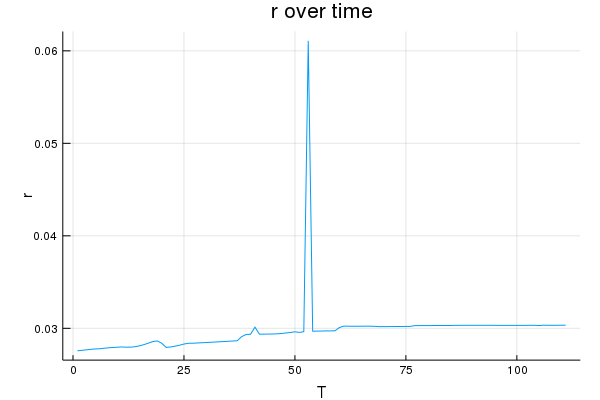

In [43]:
plot(solved.r, legend = false, title = "r over time", xlabel = "T", ylabel = "r")

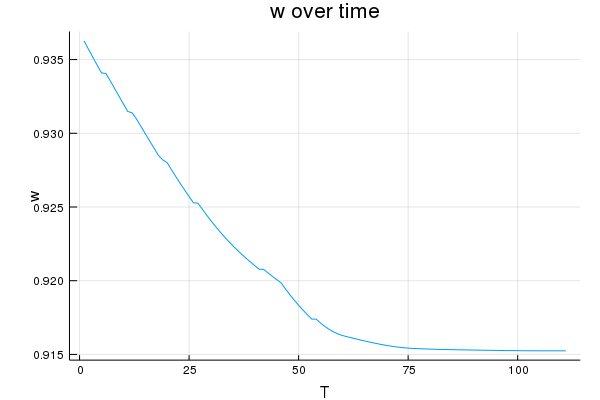

In [44]:
plot(solved.w, legend = false, title = "w over time", xlabel = "T", ylabel = "w")

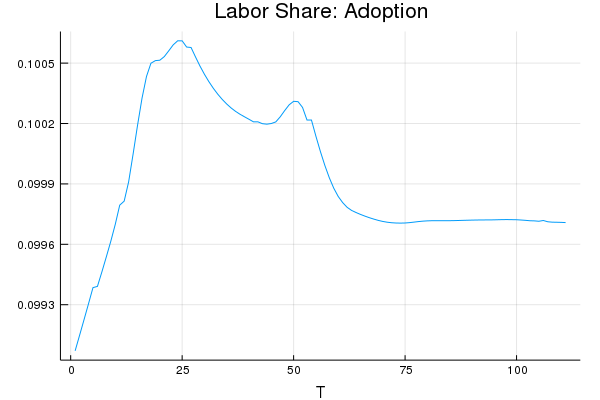

In [45]:
plot(solved.L_tilde_a, legend = false, xlabel = "T", title = "Labor Share: Adoption")

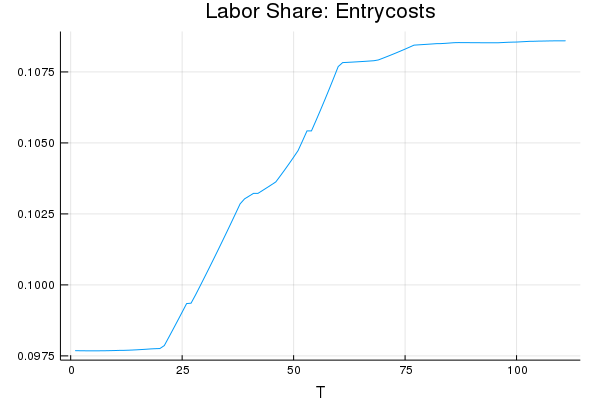

In [46]:
plot(solved.L_tilde_E, legend = false, xlabel = "T", title = "Labor Share: Entrycosts")

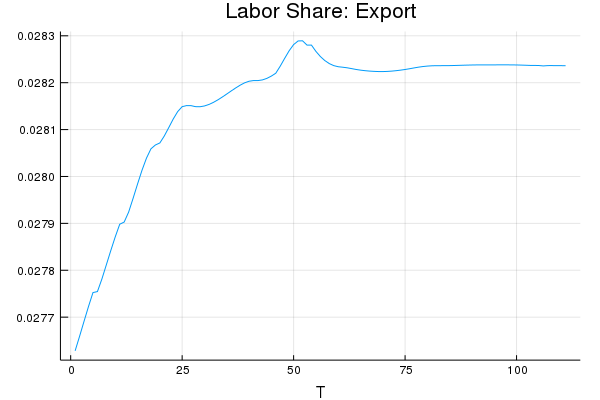

In [47]:
plot(solved.L_tilde_x, legend = false, xlabel = "T", title = "Labor Share: Export")